In [1]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import gym

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class DeepSARSA:
    def __init__(self, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = 0.001
        self.gamma = 0.99
        self.epsilon = 1.
        self.epsilon_decay = .99995
        self.epsilon_min = 0.01
        self.model = nn.Sequential(
            nn.Linear(self.num_states, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, self.num_actions)
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)
        
    def update(self, state, action, reward, next_state, next_action, done):
        self.decrease_epsilon()
        self.optimizer.zero_grad()
        
        q_value = self.model(state)[action]
        next_q_value = self.model(next_state)[next_action].detach()
        
        q_target = reward + (1 - int(done)) * self.gamma * next_q_value
        q_error = (q_target - q_value) ** 2
        
        q_error.backward()
        self.optimizer.step()
        
        return q_error.item()
    
    def decrease_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            q_values = self.model(state)
            action = torch.argmax(q_values).item()
            
        return action

In [3]:
import gym
from gym import wrappers
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, "./video", force=True)
observation = env.reset()
agent = DeepSARSA(4,2)

observation

/home/johnny/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([ 0.02680645,  0.00791713, -0.03561815,  0.00689243])

In [5]:
rewards = []
for ep in range(500):
    done = False
    obs = torch.FloatTensor(env.reset())
    action = agent.act(obs)

    ep_rewards = 0
    losses = []
    while not done:
        next_obs, reward, done, info = env.step(action)
        next_obs = torch.FloatTensor(next_obs)

        next_action = agent.act(next_obs)

        loss = agent.update(obs, action, reward, next_obs, next_action, done)
        losses.append(loss)
        
        ep_rewards += reward
        obs = next_obs
        action = next_action
    rewards.append(ep_rewards)
    ep_loss = sum(losses) / len(losses)
    if (ep+1) % 10 == 0:
        print("episode: {}, eps: {:.3f}, loss: {:.1f}, rewards: {}".format(ep+1, agent.epsilon, ep_loss, ep_rewards))
env.close()


episode: 10, eps: 0.991, loss: 2.2, rewards: 17.0
episode: 20, eps: 0.976, loss: 2.7, rewards: 68.0
episode: 30, eps: 0.964, loss: 11.4, rewards: 27.0
episode: 40, eps: 0.952, loss: 27.2, rewards: 12.0
episode: 50, eps: 0.942, loss: 5.3, rewards: 68.0
episode: 60, eps: 0.934, loss: 10.1, rewards: 16.0
episode: 70, eps: 0.922, loss: 11.9, rewards: 26.0
episode: 80, eps: 0.913, loss: 9.6, rewards: 21.0
episode: 90, eps: 0.905, loss: 3.8, rewards: 32.0
episode: 100, eps: 0.895, loss: 13.9, rewards: 17.0
episode: 110, eps: 0.882, loss: 13.4, rewards: 23.0
episode: 120, eps: 0.872, loss: 11.9, rewards: 28.0
episode: 130, eps: 0.858, loss: 11.4, rewards: 45.0
episode: 140, eps: 0.849, loss: 22.2, rewards: 15.0
episode: 150, eps: 0.839, loss: 6.4, rewards: 19.0
episode: 160, eps: 0.826, loss: 12.5, rewards: 19.0
episode: 170, eps: 0.814, loss: 12.4, rewards: 22.0
episode: 180, eps: 0.795, loss: 32.6, rewards: 30.0
episode: 190, eps: 0.784, loss: 12.5, rewards: 74.0
episode: 200, eps: 0.773, l

In [6]:
from utils import show_video

show_video()

In [7]:
pd.Series(rewards).to_csv('./logs/rewards_deepsarsa.csv')

/home/johnny/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


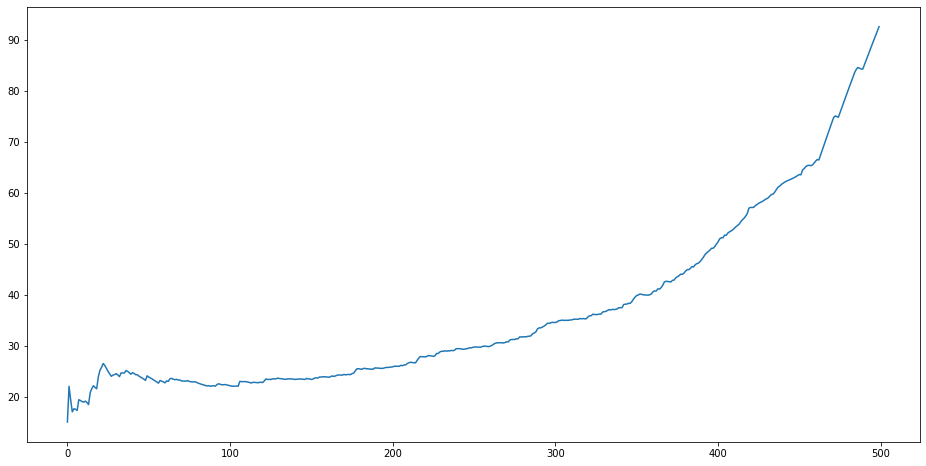

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(pd.Series(rewards).cumsum() / (pd.Series(np.arange(len(rewards)))+1))